In [3]:
# --- Cell 1: Setup Environment and Imports --
# Install dependencies (run only once)
!pip install earthengine-api geemap

# Import required libraries
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize inline plotting for Jupyter
%matplotlib inline


In [4]:
# --- Cell 2: Authenticate and Initialize GEE ---

# Authenticate (only first time or when session expires)
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize(
    project = 'vegetation-monitoring-474607'
)

print("✅ Earth Engine authenticated and initialized successfully!")


✅ Earth Engine authenticated and initialized successfully!


In [2]:
pip freeze requirements.txt > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
# --- Cell 3: Define AOI (User Input) ---

# Create an interactive map centered globally
Map = geemap.Map(center=[0, 0], zoom=2)
Map.add_basemap('SATELLITE')
Map.add_draw_control()  # allows user to draw polygons
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [6]:
# --- Cell 4: Retrieve AOI geometry from the map ---

# Get the drawn polygon
aoi = Map.user_roi

if aoi is None:
    raise ValueError("❌ Please draw an AOI on the map above before running this cell.")
else:
    print("✅ AOI captured successfully!")
    Map.center_object(aoi)
    Map.addLayer(aoi, {'color': 'red'}, 'AOI')
    Map


✅ AOI captured successfully!


In [6]:
# --- Cell 5: Load and Filter MODIS LST Data ---

# Define time range (you can modify these)
start_date = '2002-01-01'
end_date = '2002-12-31'

# Load MODIS LST (Daytime)
dataset = (
    ee.ImageCollection('MODIS/061/MOD11A1') # ee.ImageCollection("MODIS/061/MOD11A1")
    .select('LST_Day_1km')
    .filterDate(start_date, end_date)
    .filterBounds(aoi)
)

# Print info about collection
count = dataset.size().getInfo()
print(f"✅ MODIS LST images loaded: {count} (from {start_date} to {end_date})")

# Display first image to verify
first_image = dataset.first().multiply(0.02).subtract(273.15)  # Convert to °C
Map.addLayer(first_image.clip(aoi), 
             {'min': 10, 'max': 40, 'palette': ['blue', 'yellow', 'red']},
             'LST Example (°C)')
Map


✅ MODIS LST images loaded: 355 (from 2002-01-01 to 2002-12-31)


Map(bottom=132356.0, center=[-1.3511930983018765, 37.05482482910157], controls=(WidgetControl(options=['positi…

In [7]:
# --- Cell 6: Compute Daily Mean Land Surface Temperature over AOI ---

# Function to scale LST to °C
def scale_lst(img):
    lst_celsius = img.multiply(0.02).subtract(273.15)
    return lst_celsius.copyProperties(img, ['system:time_start'])

# Apply scaling
lst_celsius = dataset.map(scale_lst)

# Function to compute mean LST over AOI
def zonal_mean(img):
    mean_dict = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=1000,      # 1 km resolution
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'mean_lst': mean_dict.get('LST_Day_1km')
    })

# Map function across all images
features = lst_celsius.map(zonal_mean).getInfo()

# Convert to Pandas DataFrame
data = [f['properties'] for f in features['features']]
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df['mean_lst'] = pd.to_numeric(df['mean_lst'], errors='coerce')

# Drop NaNs and sort by date
df = df.dropna(subset=['mean_lst']).sort_values('date')

print("✅ Extracted mean daily LST values:")
df.head()


✅ Extracted mean daily LST values:


,date,mean_lst
1,2002-01-02,31.178848
2,2002-01-03,33.011914
3,2002-01-04,24.521304
4,2002-01-05,27.903808
5,2002-01-06,26.939301


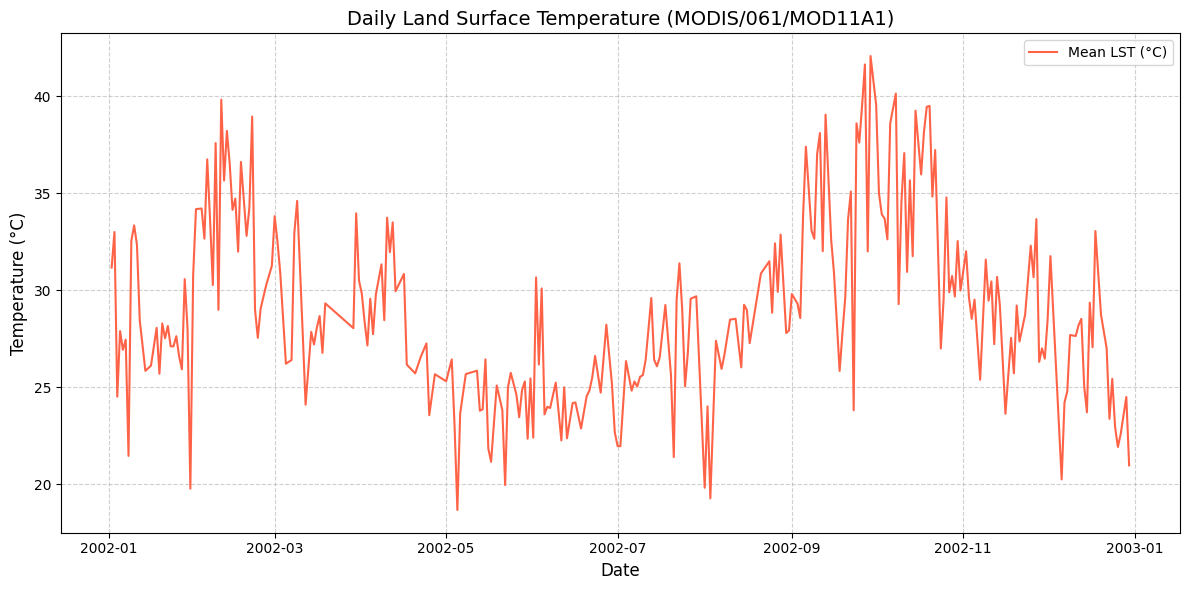

In [8]:
# --- Cell 7: Plot Daily Mean Land Surface Temperature Time Series ---

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['mean_lst'], color='tomato', linewidth=1.5, label='Mean LST (°C)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Daily Land Surface Temperature (MODIS/061/MOD11A1)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# --- Cell 8: Export Results to CSV ---

# Define output file name
output_csv = "MODIS_LST_Daily_TimeSeries.csv"

# Export to CSV
df.to_csv(output_csv, index=False)

print(f"✅ Export complete! File saved locally as: {output_csv}")


✅ Export complete! File saved locally as: MODIS_LST_Daily_TimeSeries.csv


# Baseline Computation

In [7]:
import pandas as pd
import ee

# Define baseline period
baseline_start = '2002-01-01'
baseline_end = '2020-12-31'

# Load MODIS daily LST for baseline years
baseline_dataset = (
    ee.ImageCollection("MODIS/061/MOD11A1")
    .select('LST_Day_1km')
    .filterDate(baseline_start, baseline_end)
    .filterBounds(aoi)
)
print("baseline data loaded successfully")

baseline data loaded successfully


In [8]:
# Convert to Celsius
def scale_lst(img):
    lst_celsius = img.multiply(0.02).subtract(273.15)
    return lst_celsius.copyProperties(img, ['system:time_start'])

baseline_dataset = baseline_dataset.map(scale_lst)

# Add year and month properties
def add_date_props(img):
    date = ee.Date(img.get('system:time_start'))
    return img.set({'year': date.get('year'), 'month': date.get('month')})

baseline_dataset = baseline_dataset.map(add_date_props)

In [9]:
def yearly_stats(year):
    records = []
    for month in range(1, 13):
        coll = (
            baseline_dataset
            .filter(ee.Filter.calendarRange(year, year, 'year'))
            .filter(ee.Filter.calendarRange(month, month, 'month'))
        )

        size = coll.size().getInfo()
        if size == 0:
            records.append({'year': year, 'month': month, 'mean': None, 'min': None, 'max': None})
            continue

        # Compute all three stats once
        mean_img = coll.mean()
        min_img = coll.min()
        max_img = coll.max()
        
        reducer = ee.Reducer.mean()
        region_stats = ee.Image.cat([
            mean_img.rename('mean'),
            min_img.rename('min'),
            max_img.rename('max')
        ]).reduceRegion(
            reducer=reducer,
            geometry=aoi,
            scale=1000,
            maxPixels=1e13
        )

        vals = region_stats.getInfo()
        records.append({
            'year': year,
            'month': month,
            'mean': vals.get('mean'),
            'min': vals.get('min'),
            'max': vals.get('max')
        })
    return records

# Run for all baseline years
records = []
for y in range(2002, 2021):
    print(f"Processing {y} ...")
    records.extend(yearly_stats(y))

baseline_df = pd.DataFrame(records)
baseline_df = baseline_df.dropna(subset=['mean'])


Processing 2002 ...
Processing 2003 ...
Processing 2004 ...
Processing 2005 ...
Processing 2006 ...
Processing 2007 ...
Processing 2008 ...
Processing 2009 ...
Processing 2010 ...
Processing 2011 ...
Processing 2012 ...
Processing 2013 ...
Processing 2014 ...
Processing 2015 ...
Processing 2016 ...
Processing 2017 ...
Processing 2018 ...
Processing 2019 ...
Processing 2020 ...


In [10]:
baseline_summary = (
    baseline_df.groupby('month')
    .agg({'mean': 'mean', 'min': 'mean', 'max': 'mean'})
    .reset_index()
    .sort_values('month')
)

print("✅ Baseline monthly climatology (2002–2020):")
display(baseline_summary)


✅ Baseline monthly climatology (2002–2020):


,month,mean,min,max
0,1,34.036505,28.475073,38.774581
1,2,35.778346,29.870258,40.738994
2,3,35.375217,29.558039,40.263370
3,4,32.234581,27.921889,36.451687
4,5,30.635724,26.563389,34.215716
5,6,29.933478,25.838916,33.560517
6,7,30.421601,26.046194,34.344092
7,8,32.442962,27.333355,37.066806
8,9,35.492268,29.355292,40.866606
9,10,36.902166,30.420656,42.431662


In [11]:
baseline_df.to_csv("MODIS_LST_Baseline_2002_2020.csv", index=False)
print("💾 Saved baseline to MODIS_LST_Baseline_2002_2020.csv")


💾 Saved baseline to MODIS_LST_Baseline_2002_2020.csv


### Analysis Phase
#### for 2021-2024 aganist the baseline

In [13]:
# Obtain the montly LST from 2021 - 2024 using the mean, min and max
# Define analysis period
analysis_years = list(range(2021, 2025))

def monthly_stats_safe(year, month):
    # Define safe start and end dates
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')  # automatically handles month lengths

    coll = (ee.ImageCollection("MODIS/061/MOD11A1")
            .select('LST_Day_1km')
            .filterDate(start_date, end_date)
            .filterBounds(aoi))
    
    size = coll.size().getInfo()
    if size == 0:
        return {'year': year, 'month': month, 'mean': None, 'min': None, 'max': None}
    
    # Convert to Celsius
    def scale(img): 
        return img.select('LST_Day_1km').multiply(0.02).subtract(273.15)
    
    coll = coll.map(scale)
    
    # Compute stats
    mean_dict = coll.mean().reduceRegion(ee.Reducer.mean(), aoi, scale=1000, maxPixels=1e13)
    min_dict = coll.min().reduceRegion(ee.Reducer.mean(), aoi, scale=1000, maxPixels=1e13)
    max_dict = coll.max().reduceRegion(ee.Reducer.mean(), aoi, scale=1000, maxPixels=1e13)
    
    return {
        'year': year,
        'month': month,
        'mean': mean_dict.getInfo().get('LST_Day_1km'),
        'min': min_dict.getInfo().get('LST_Day_1km'),
        'max': max_dict.getInfo().get('LST_Day_1km')
    }

# Loop through years and months for analysis period
records_analysis = []
for y in analysis_years:
    for m in range(1, 13):
        record = monthly_stats_safe(y, m)
        records_analysis.append(record)

analysis_df = pd.DataFrame(records_analysis)
analysis_df = analysis_df.dropna(subset=['mean'])

print("✅ Analysis data (2021–2024) collected successfully.")
display(analysis_df.head())


✅ Analysis data (2021–2024) collected successfully.


,year,month,mean,min,max
0,2021,1,32.729785,27.673526,37.236192
1,2021,2,34.361684,28.961000,39.093449
2,2021,3,35.888667,29.996149,40.953654
3,2021,4,31.633285,27.718588,35.670960
4,2021,5,30.682839,27.317386,33.812540


### Compute Anomalies

In [14]:
# Ensure baseline_summary exists from earlier step
# baseline_summary columns: ['month', 'mean', 'min', 'max']

# Merge analysis data with baseline climatology
analysis_with_anomaly = analysis_df.merge(
    baseline_summary,
    on='month',
    suffixes=('_obs', '_baseline')
)

# Compute anomalies (observed - baseline)
analysis_with_anomaly['mean_anomaly'] = (
    analysis_with_anomaly['mean_obs'] - analysis_with_anomaly['mean_baseline']
)
analysis_with_anomaly['min_anomaly'] = (
    analysis_with_anomaly['min_obs'] - analysis_with_anomaly['min_baseline']
)
analysis_with_anomaly['max_anomaly'] = (
    analysis_with_anomaly['max_obs'] - analysis_with_anomaly['max_baseline']
)

print("✅ Temperature anomalies computed successfully.")
display(analysis_with_anomaly.head())


✅ Temperature anomalies computed successfully.


,year,month,mean_obs,min_obs,max_obs,mean_baseline,min_baseline,max_baseline,mean_anomaly,min_anomaly,max_anomaly
0,2021,1,32.729785,27.673526,37.236192,34.036505,28.475073,38.774581,-1.306720,-0.801547,-1.538389
1,2021,2,34.361684,28.961000,39.093449,35.778346,29.870258,40.738994,-1.416662,-0.909258,-1.645544
2,2021,3,35.888667,29.996149,40.953654,35.375217,29.558039,40.263370,0.513449,0.438110,0.690284
3,2021,4,31.633285,27.718588,35.670960,32.234581,27.921889,36.451687,-0.601297,-0.203301,-0.780727
4,2021,5,30.682839,27.317386,33.812540,30.635724,26.563389,34.215716,0.047114,0.753997,-0.403176


In [26]:
analysis_with_anomaly.to_csv("MODIS_LST_Baseline_2002_2020_Anomalies.csv", index=False)
print("💾 Saved baseline to MODIS_LST_Baseline_2002_2020_Anomalies.csv")

💾 Saved baseline to MODIS_LST_Baseline_2002_2020_Anomalies.csv


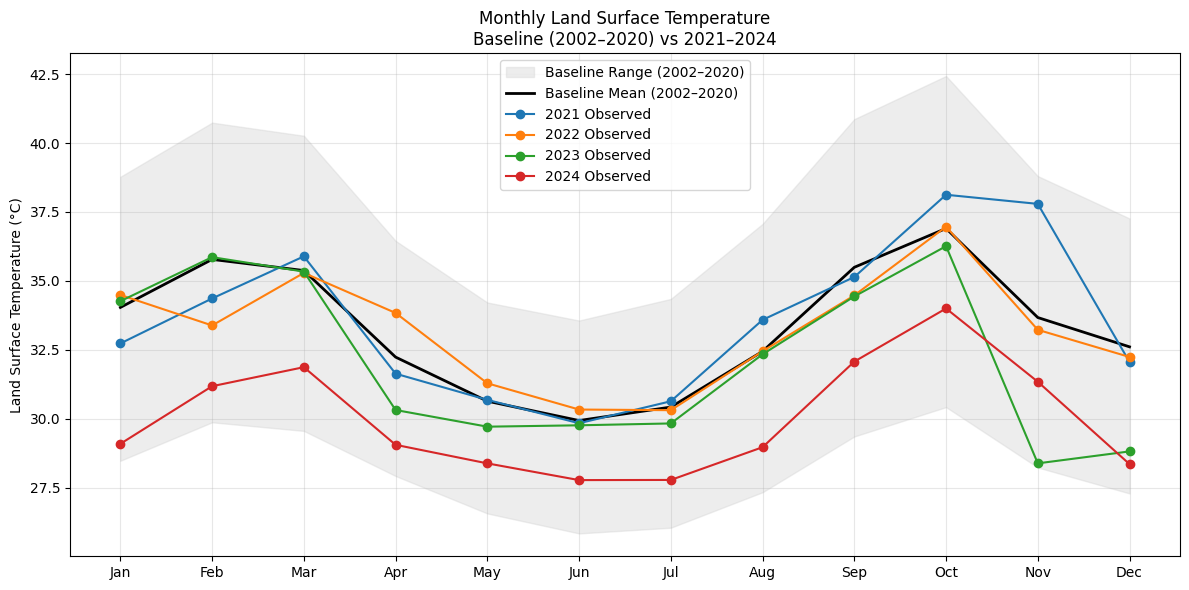

✅ Plot saved as: ./plots\monthly_temperature_baseline_vs_recent.png


In [29]:
import matplotlib.pyplot as plt
import os

# Create folder for plots
png_folder = "./plots"
os.makedirs(png_folder, exist_ok=True)

# Path for output
png_path = os.path.join(png_folder, "monthly_temperature_baseline_vs_recent.png")

plt.figure(figsize=(12,6))

# --- Baseline shaded range (fixed, same for all years) ---
plt.fill_between(
    baseline_summary['month'],
    baseline_summary['min'],
    baseline_summary['max'],
    color='lightgray',
    alpha=0.4,
    label='Baseline Range (2002–2020)'
)

# --- Baseline mean line ---
plt.plot(
    baseline_summary['month'],
    baseline_summary['mean'],
    color='black',
    linewidth=2,
    label='Baseline Mean (2002–2020)'
)

# --- Plot observed (recent) years ---
for y in range(2021, 2025):
    data_y = analysis_with_anomaly[analysis_with_anomaly['year'] == y]
    plt.plot(
        data_y['month'],
        data_y['mean_obs'],
        marker='o',
        label=f"{y} Observed"
    )

# --- Formatting ---
plt.xticks(
    range(1,13),
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)
plt.ylabel("Land Surface Temperature (°C)")
plt.title("Monthly Land Surface Temperature\nBaseline (2002–2020) vs 2021–2024")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig(png_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as: {png_path}")


In [32]:
import matplotlib.pyplot as plt
import os

# Folder to save yearly plots
png_folder = "./plots_yearly"
os.makedirs(png_folder, exist_ok=True)

for y in range(2021, 2025):
    data_y = analysis_with_anomaly[analysis_with_anomaly['year'] == y]
    png_path = os.path.join(png_folder, f"monthly_temperature_{y}.png")

    plt.figure(figsize=(10,6))

    # --- Baseline shaded range ---
    plt.fill_between(
        baseline_summary['month'],
        baseline_summary['min'],
        baseline_summary['max'],
        color='lightgray',
        alpha=0.4,
        label='Baseline Range (2002–2020)'
    )

    # --- Baseline mean line ---
    plt.plot(
        baseline_summary['month'],
        baseline_summary['mean'],
        color='black',
        linewidth=2,
        label='Baseline Mean (2002–2020)'
    )

    # --- Observed LST for that year ---
    plt.plot(
        data_y['month'],
        data_y['mean_obs'],
        marker='o',
        color='tomato',
        linewidth=2,
        label=f'{y} Observed'
    )

    # --- Formatting ---
    plt.xticks(
        range(1,13),
        ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    )
    plt.ylabel("Land Surface Temperature (°C)")
    plt.title(f"Monthly Land Surface Temperature – {y}\nvs Baseline (2002–2020)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Save each figure
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close to save memory

    print(f"✅ Saved plot for {y}: {png_path}")


✅ Saved plot for 2021: ./plots_yearly\monthly_temperature_2021.png
✅ Saved plot for 2022: ./plots_yearly\monthly_temperature_2022.png
✅ Saved plot for 2023: ./plots_yearly\monthly_temperature_2023.png
✅ Saved plot for 2024: ./plots_yearly\monthly_temperature_2024.png


### Based on the anomalies

In [36]:
for y in range(2021, 2025):
    data_y = analysis_with_anomaly[analysis_with_anomaly['year'] == y]
    png_path = os.path.join(png_folder, f"Temperature_Anomalies_{y}.png")

    plt.figure(figsize=(10,6))

    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.plot(
        data_y['month'],
        data_y['mean_anomaly'],
        marker='o',
        color='royalblue',
        linewidth=2,
        label=f'{y} Anomaly'
    )

    plt.xticks(
        range(1,13),
        ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    )
    plt.ylabel("Temperature Anomaly (°C)")
    plt.title(f"Monthly Temperature Anomalies – {y}\nRelative to Baseline (2002–2020)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"✅ Saved anomaly plot for {y}: {png_path}")


✅ Saved anomaly plot for 2021: ./plots_yearly/Anomalies\Temperature_Anomalies_2021.png
✅ Saved anomaly plot for 2022: ./plots_yearly/Anomalies\Temperature_Anomalies_2022.png
✅ Saved anomaly plot for 2023: ./plots_yearly/Anomalies\Temperature_Anomalies_2023.png
✅ Saved anomaly plot for 2024: ./plots_yearly/Anomalies\Temperature_Anomalies_2024.png


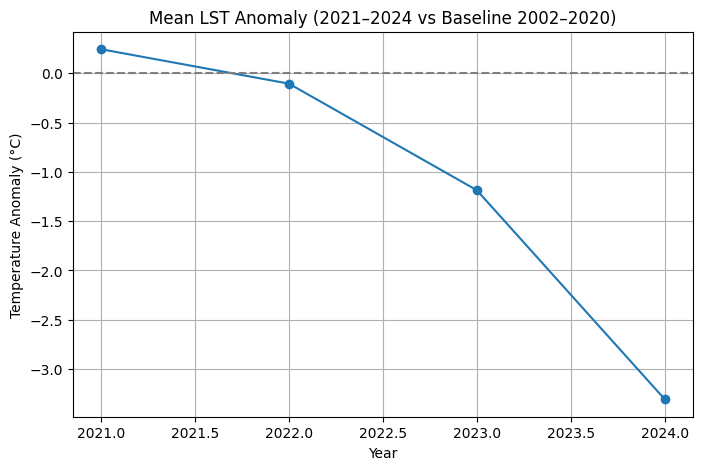

In [15]:
# Visualization
import matplotlib.pyplot as plt

# Compute mean anomaly per year
yearly_anomaly = (
    analysis_with_anomaly.groupby('year')
    .agg({'mean_anomaly': 'mean'})
    .reset_index()
)

plt.figure(figsize=(8,5))
plt.plot(yearly_anomaly['year'], yearly_anomaly['mean_anomaly'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Mean LST Anomaly (2021–2024 vs Baseline 2002–2020)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.grid(True)
plt.show()


In [19]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 508.0 kB/s eta 0:00:17
   -- ------------------------------------- 0.5/8.9 MB 508.0 kB/s eta 0:00:17
   -- ------------------------------------- 0.5/8.9 MB 508.0 kB/s eta 0:00:17
   --- ------------------------------------ 0.8/8.9 MB 479.2 kB/s eta 0:00:17
   --- ------------------------------------ 0.8/8.9 MB 479.2 kB/s eta 0:00:17
   ---- ----------------------------------- 1.0/8.9 MB 470.4 kB/s eta 0:00:17
   ---- ----------------------------------- 1.0/8.9 MB 470.4 kB/s eta 0:00:17
   ----- -------------------------------

In [21]:
analysis_df.columns.tolist()

['year', 'month', 'mean', 'min', 'max']

In [22]:
# Trend Analysis per year
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Ensure your dataframe is sorted
analysis_with_anomaly = analysis_with_anomaly.sort_values(['year', 'month'])

trend_records = []

for year in analysis_with_anomaly['year'].unique():
    df_year = analysis_with_anomaly[analysis_with_anomaly['year'] == year]
    
    # Independent variable (months)
    X = df_year['month'].values.reshape(-1, 1)
    y = df_year['mean_anomaly'].values
    
    if len(df_year) >= 3:
        model = LinearRegression()
        model.fit(X, y)
        slope = model.coef_[0]
        r2 = model.score(X, y)
        trend_records.append({'year': year, 'slope': slope, 'r2': r2})

trend_df = pd.DataFrame(trend_records)
print("📈 Yearly anomaly trend stats:")
display(trend_df)


📈 Yearly anomaly trend stats:


,year,slope,r2
0,2021,0.237722,0.338135
1,2022,-0.020860,0.006009
2,2023,-0.316216,0.446684
3,2024,0.094166,0.135820


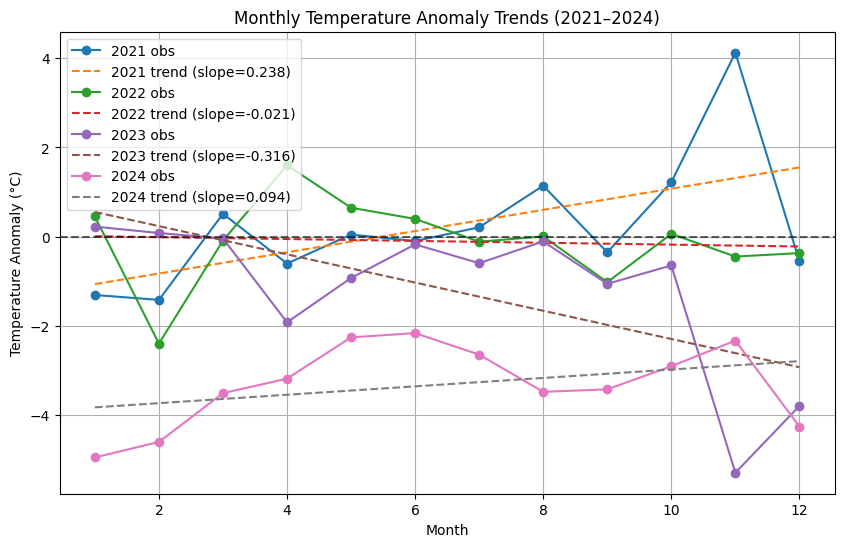

In [23]:
#
plt.figure(figsize=(10, 6))

for year in analysis_with_anomaly['year'].unique():
    df_year = analysis_with_anomaly[analysis_with_anomaly['year'] == year]
    X = np.array(df_year['month'])
    y = np.array(df_year['mean_anomaly'])
    
    # Fit regression line
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    
    plt.plot(X, y, 'o-', label=f'{year} obs')
    plt.plot(X, y_pred, '--', label=f'{year} trend (slope={model.coef_[0]:.3f})')

plt.axhline(0, color='k', linestyle='--', alpha=0.6)
plt.title('Monthly Temperature Anomaly Trends (2021–2024)')
plt.xlabel('Month')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.grid(True)
plt.show()


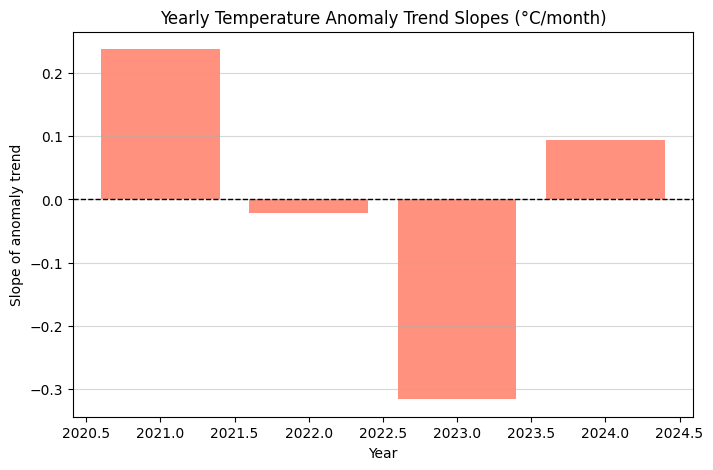

In [24]:
plt.figure(figsize=(8, 5))
plt.bar(trend_df['year'], trend_df['slope'], color='tomato', alpha=0.7)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title('Yearly Temperature Anomaly Trend Slopes (°C/month)')
plt.xlabel('Year')
plt.ylabel('Slope of anomaly trend')
plt.grid(axis='y', alpha=0.5)
plt.show()
